# Python Libraries

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import calendar
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


%matplotlib inline

# Set Parameters

In [2]:
# Some parameters to use in the models later

testsize = 0.3
randomstate = 2020

param = {'max_depth': np.arange(3, 10),
         'criterion': ['gini', 'entropy'],
         'max_leaf_nodes': [5, 10, 20, 100],
         'min_samples_split': [2, 5, 10, 20]}

<b> Reading the Data <b/>

We have 2 datasets (train and test) for this project.  Train dataset has more than 55M rows, therefore we can't import all of it. We will use read 8M rows in our project. 

In [3]:
train = pd.read_csv(
    'new-york-city-taxi-fare-prediction/train.csv', nrows=8000000)
test = pd.read_csv('new-york-city-taxi-fare-prediction/test.csv')

# Data Exploration and Data Cleaning

## Data Cleaning 

In this section, we will look at the datasets closely. We will check if the datasets are missing any values. We will check if there are anomalies, clear outliers and format the dataset for visualization and model building. 

In [4]:
# First glance at the dataset

train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000000 entries, 0 to 7999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 488.3+ MB


In [6]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,8.000000e+06,8.000000e+06,8.000000e+06,7.999951e+06,7.999951e+06,8.000000e+06
mean,1.133914e+01,-7.251302e+01,3.992341e+01,-7.251237e+01,3.992143e+01,1.684721e+00
std,9.807189e+00,1.289849e+01,9.122808e+00,1.285973e+01,9.311601e+00,1.324929e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399208e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398182e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076711e+01,-7.396368e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


<p>Couple things we notice after first glance, key column seems unnecessary to keep since basically the same with pickup_datetime column. So we can remove it.<p/>

<p> Also, There are negative values on fare_amount column we need to remove.<p/>

<p> 

In [7]:
# Removing key column for the datasets

train = train.drop('key', axis=1)
test = test.drop('key', axis=1)

In [8]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Let's check if there is any missing data on the dataset. 

In [9]:
train.isnull().sum()

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    49
dropoff_latitude     49
passenger_count       0
dtype: int64

There are 36 NAN in each dropoff_longitude and dropoff_latitude column. We will drop those NAN data.


In [10]:
train = train.dropna()

Let's check row number now. We removed 36 rows with NAN.

In [11]:
len(train)

7999951

<p>On the describe table, we saw that there are negative fare amount in the dataset. We will remove them as well.Also, we will remove the fare amount greater than $200 which I  believe it is the most expensive cab ride you can ever take in New York City.<p/>

<p> In NYC, initial charge is \$2.5 plus 50 cent surcharge is added to the fare at the end of the cab ride. Therefore, we will also remove the fare less than \$3 as well.

In [12]:
train = train[(train['fare_amount'] > 3) & (train['fare_amount'] < 200)]

Let's check our new row count

In [13]:
len(train)

7932680

By law, NYC taxi cabs are not allowed to carry more than four people. Therefore we will remove the data that has more passenger than four in passenger_count

In [14]:
train = train[(train['passenger_count'] < 5)]

In [15]:
len(train)

7202888

Wow, we removed more than four hundred thousand rows with passenger size more than four.

In [16]:
train = train[(train['pickup_longitude'] != train['dropoff_longitude']) & (
    train['pickup_latitude'] != train['dropoff_latitude'])]

Above, we also removed the rows that has the same pickup and drop off coordinates. 

In [17]:
len(train)

7003498

NY city's Latitude and longitude coordinates are ( 40.73, -73.93), therefore we will remove any pickup coordinates that don't fall under between these coordinates. I don't want to apply this to drop off coordinates since I want to include the cab rides start from NYC to other close states such as New Jersey, Connecticut etc.

In [18]:
# Remove latitude and longtiude outliers
train = train[train['pickup_latitude'].between(40, 41)]
train = train[train['pickup_longitude'].between(-74, -73)]

In [19]:
len(train)

6045217

## Feature Engineering

We will convert pickup_datetime column to datetime, then we can use hour,day and year in our prediction models. 

In [20]:
# Converting to datetime

train['pickup_datetime'] = pd.to_datetime(
    train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [21]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1
6,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1


In [22]:
# adding hour, day, day of the week, month and year columns
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(
    lambda x: calendar.day_name[x.weekday()])
train['pickup_month'] = train['pickup_datetime'].apply(lambda x: x.month)
train['pickup_year'] = train['pickup_datetime'].apply(lambda x: x.year)

In [23]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,15,17,Monday,6,2009
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,18,0,Thursday,8,2011
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,21,4,Saturday,4,2012
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,9,7,Tuesday,3,2010
6,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,20,20,Tuesday,11,2012


We will measure the distance for each cab ride by using __Haversine distance formula__. Haversine distance measures the distance between two points by using coordinates and taking into account the spherical shape of the Earth. The code below to calculate Haversine distance is from a Stack Overflow answer that you can see the link in comments:

In [24]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    radius = 6371.01

    km = radius * c

    return km

In [25]:
train['distance_in_km'] = haversine_np(train['pickup_longitude'], train['pickup_latitude'],
                                       train['dropoff_longitude'], train['dropoff_latitude'])

test['distance_in_km'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                                      test['dropoff_longitude'], test['dropoff_latitude'])

In [26]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,distance_in_km
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,15,17,Monday,6,2009,1.030766
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,18,0,Thursday,8,2011,1.389527
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,21,4,Saturday,4,2012,2.799275
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,9,7,Tuesday,3,2010,1.999160
6,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,20,20,Tuesday,11,2012,1.555809


The longest ride should not be more than 150 km in NYC even considering the rides picked up from the city to close states like NJ or PA.Thus, we should remove the rides longer than 150 km. 

In [27]:
train = train[train["distance_in_km"] < 150]

In [28]:
train.shape

(6040213, 13)

## Data Visualization

We will create some plots to see the correlation between the features and the target, and we will answer some questions that will help exploring the data and make meaningful predictions later on.

__Fare Amount Distribution__

Text(0.5, 0, 'Fare Amount')

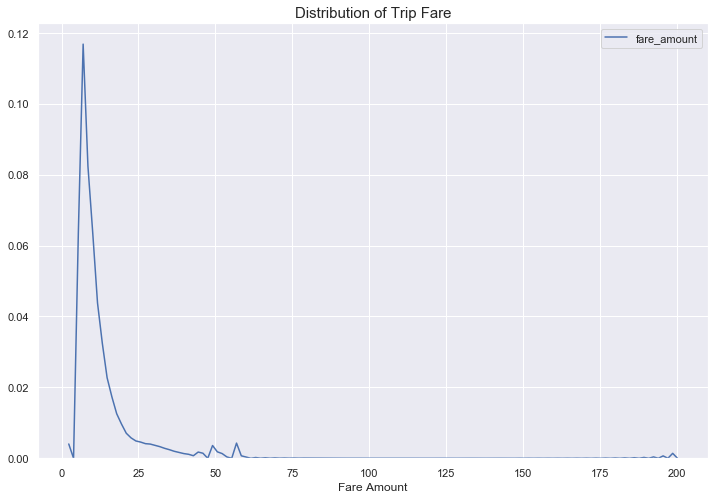

In [29]:
sns.set()
plt.figure(figsize=(12, 8))
sns.kdeplot(train['fare_amount']).set_title(
    "Distribution of Trip Fare", fontsize=15)
plt.xlabel('Fare Amount')

We should take log of fare amount since plot is heavily "right skewed". Our plot will make more sense with logged fare amount.

Text(0.5, 0, 'Fare Amount')

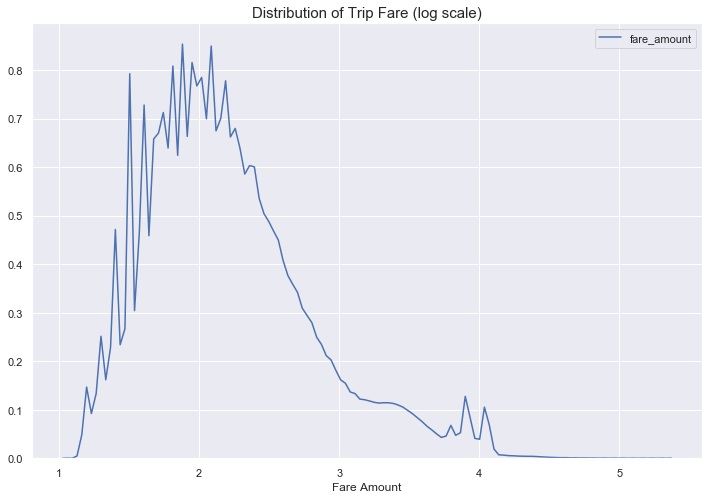

In [30]:
sns.set()
plt.figure(figsize=(12, 8))
sns.kdeplot(np.log(train['fare_amount']))
plt.title("Distribution of Trip Fare (log scale)", fontsize=15)
plt.xlabel('Fare Amount')

Most of the rides cost less than 25 dollars, average fare amount is \\$11.32 and median is \\$8.5

__Trip Distance vs. Fare Amount__

We will check the relationship between trip distance and fare amount. It should be linear relationship between them, we will create a plot and see if it does.

Text(0, 0.5, 'Fare Amount')

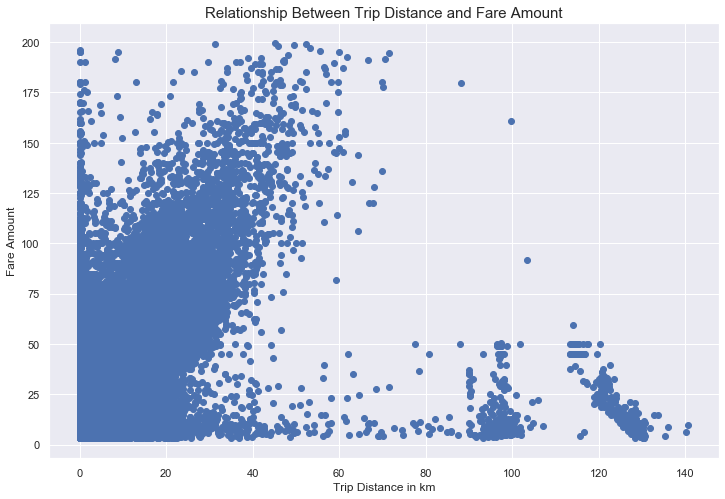

In [31]:
sns.set()
plt.figure(figsize=(12, 8))
plt.scatter(train.distance_in_km, train.fare_amount)
plt.title("Relationship Between Trip Distance and Fare Amount", fontsize=15)
plt.xlabel('Trip Distance in km')
plt.ylabel('Fare Amount')

As we expected, fare amount increases with the distance traveled for the most of the rides. There is a good amount of the rides with longer distance and less than \$50. It could be the airport rides since there is a flat rate policy to/from NY airports.

<p> However, there are good amount of rides that don't make much sense on the upper left corner ( very short distance and higher than $100), we will remove those rides as well. <p/>

In [32]:
# removing the ride cost more $100 with less than 5 km
c = train[(train.distance_in_km < 5) & (train.fare_amount > 100)]
train = train.drop(c.index)

In [33]:
train.shape

(6039994, 13)

Text(0, 0.5, 'Fare Amount')

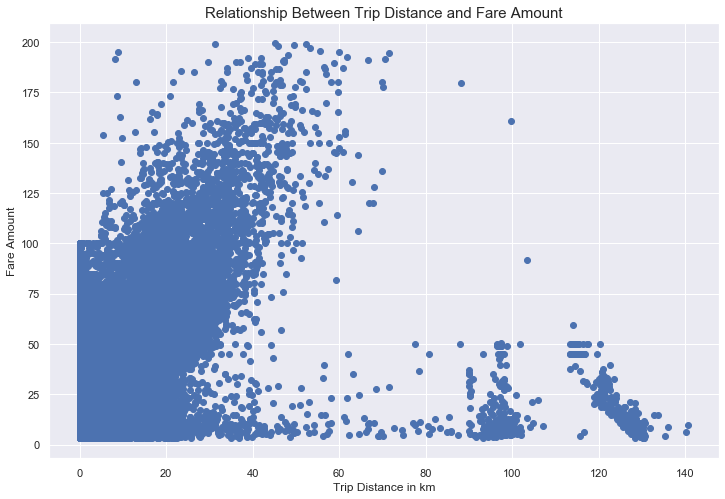

In [34]:
# Let's plot again!
sns.set()
plt.figure(figsize=(12, 8))
plt.scatter(train.distance_in_km, train.fare_amount)
plt.title("Relationship Between Trip Distance and Fare Amount", fontsize=15)
plt.xlabel('Trip Distance in km')
plt.ylabel('Fare Amount')

__Passenger Number vs. Fare Amount__

We want to investigate if there is a correlation between passenger number and fare amount. Also, we can check the passanger number for the most of the cab ride. Let's start creating our plots.

Text(0, 0.5, 'Frequency')

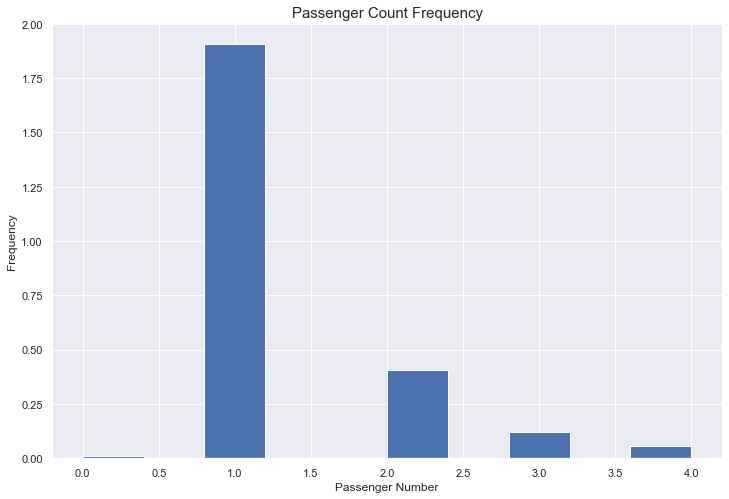

In [35]:
sns.set()
plt.figure(figsize=(12, 8))
plt.hist(train.passenger_count, density= True, bins = 10)
plt.title("Passenger Count Frequency", fontsize=15)
plt.xlabel('Passenger Number')
plt.ylabel('Frequency')

Most of the rides is with one passenger, we can see a small amount of rides with no passengers. This needs further investigation. 

In [36]:
# Checking if there is any rides without any passenger
train[train.passenger_count  == 0].shape


(23639, 13)

There are 23639 rides with no passenger in our dataset. We will remove these rides because rides without passenger is not a cab ride at all! 

In [37]:
train = train[train.passenger_count != 0]

Text(0, 0.5, 'Frequency')

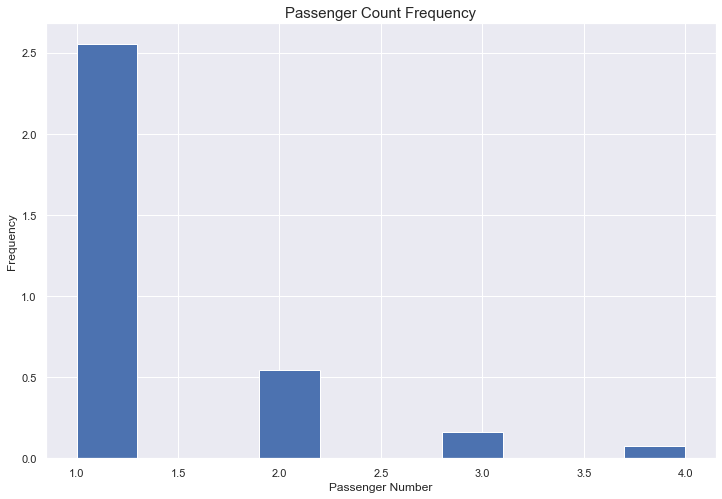

In [38]:
# Now 
sns.set()
plt.figure(figsize=(12, 8))
plt.hist(train.passenger_count, density= True, bins = 10)
plt.title("Passenger Count Frequency", fontsize=15)
plt.xlabel('Passenger Number')
plt.ylabel('Frequency')

Our plot looks better now, 1 passenger is the most frequent and 4 passenger is least frequent.

Text(0, 0.5, 'Frequency')

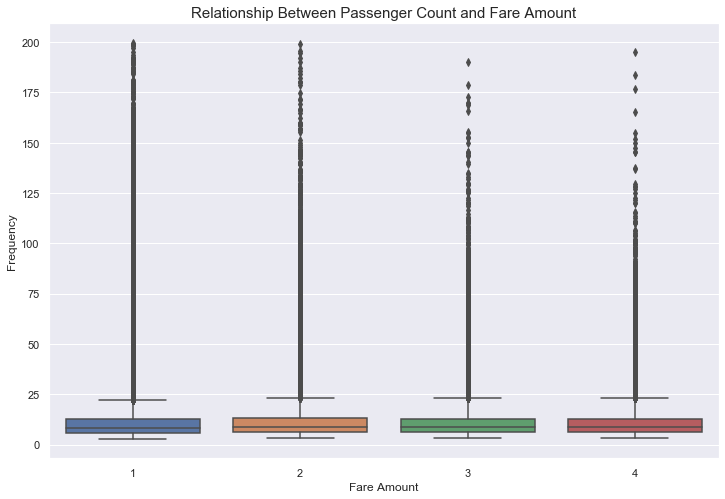

In [39]:
# Creating plot showing correlation between passenger count and fare amount
sns.set()
plt.figure(figsize=(12, 8))
sns.boxplot(train.passenger_count, train.fare_amount)
plt.title("Relationship Between Passenger Count and Fare Amount", fontsize=15)
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')

The box for each passenger count look similar, they have same median and whiskers. That makes us think that fare amount and passenger count is not correlated much. We can check the correlation between them.

In [40]:
train[['fare_amount','passenger_count']].corr()

,fare_amount,passenger_count
fare_amount,1.00000,0.02263
passenger_count,0.02263,1.00000


As we suspected, there is little correlation between passenger count and fare amount. We will take this into consideration we build our models.

__Pick up Hour vs. Fare Amount__

We will create plots to check if the fare amount changes depends on the time, date, month or the year. Let's start with time, we will check if there is a pattern we can see.

Text(0, 0.5, 'Average Fare Amount')

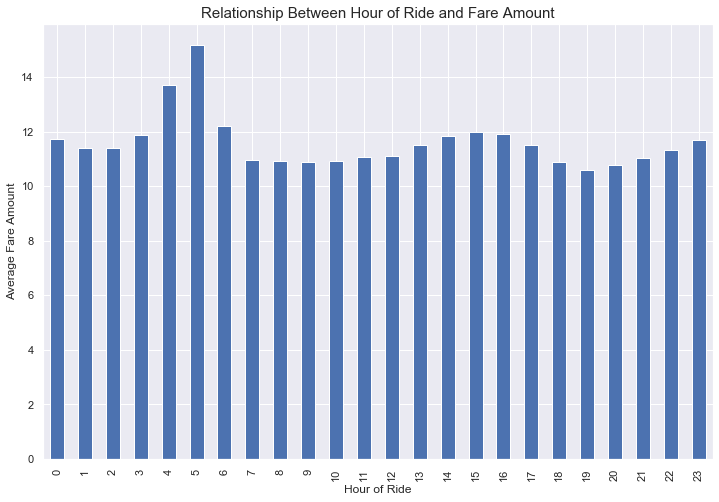

In [49]:
sns.set()
plt.figure(figsize=(12, 8))
train.groupby('pickup_hour')['fare_amount'].mean().plot.bar()
plt.title("Relationship Between Hour of Ride and Fare Amount", fontsize=15)
plt.xlabel('Hour of Ride')
plt.ylabel('Average Fare Amount')

Average fare amount is similar expect the rides take place at 4 AM and 5 AM. Average rate is the highest at 5 AM.


Text(0, 0.5, 'Total Ride Amount')

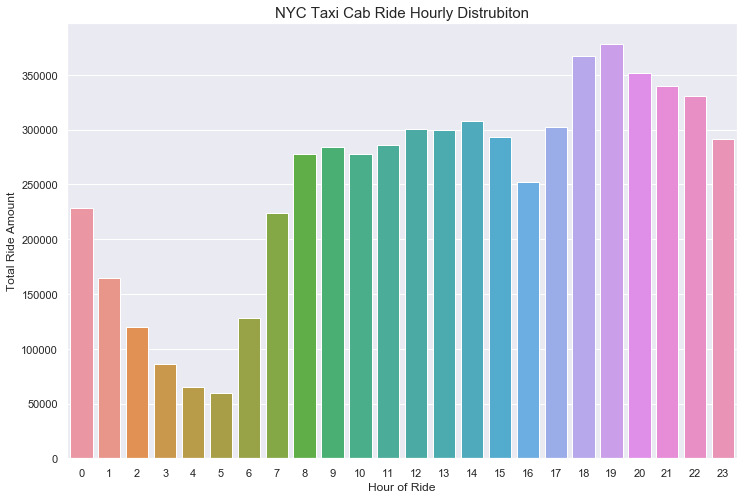

In [52]:
sns.set()
plt.figure(figsize=(12, 8))
sns.countplot('pickup_hour', data = train)
plt.title('NYC Taxi Cab Ride Hourly Distrubiton', fontsize=15)
plt.xlabel('Hour of Ride')
plt.ylabel('Total Ride Amount')

The least busy time of the day for the taxi cabs in NYC is 4 AM and 5 AM, the busiest time is between 6 PM to 7 PM which makes sense since it is rush hour. The amount of the rides increases from morning till 7 PM, then it decreases till it reaches the lowest level at 7 AM.

__Pick Up Day vs. Fare Amount__

Text(0, 0.5, 'Total Ride Amount')

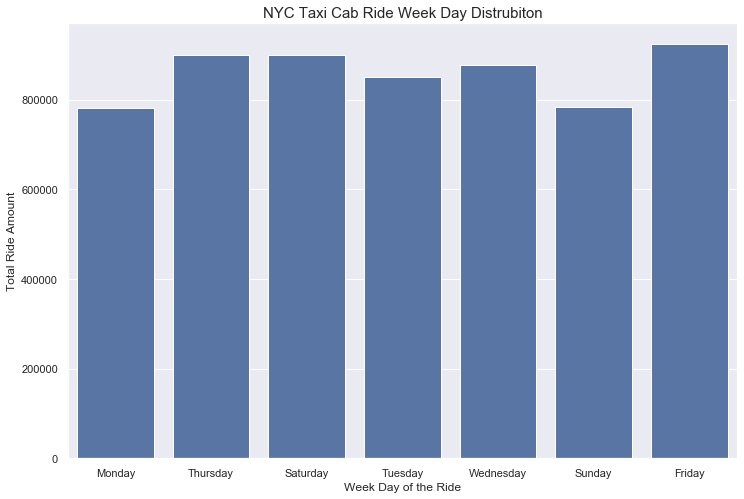

In [82]:
sns.set()
plt.figure(figsize=(12, 8))
sns.countplot('pickup_day_of_week', data = train, color = 'b')
plt.title('NYC Taxi Cab Ride Week Day Distrubiton', fontsize=15)
plt.xlabel('Week Day of the Ride')
plt.ylabel('Total Ride Amount')

Sundays and Mondays are the least busiest days of the week. Total amount of the rides increases from Monday through Friday. Friday is the busiest day.

Text(0, 0.5, 'Average Fare Amount')

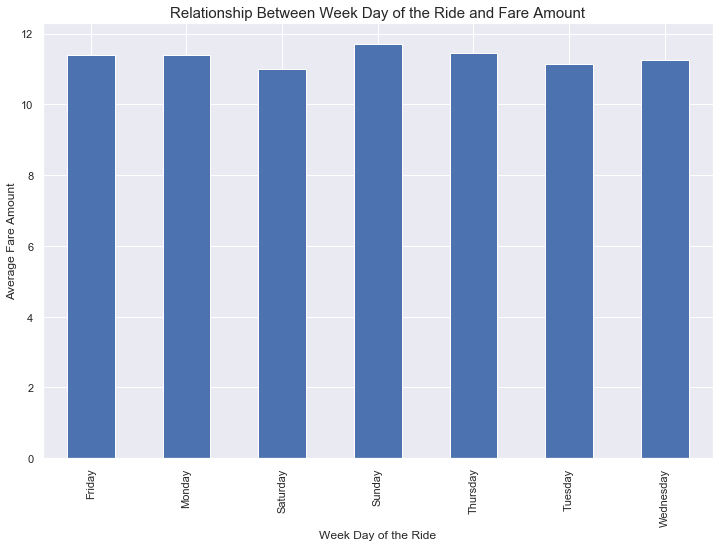

In [89]:
sns.set()
plt.figure(figsize=(12, 8))
train.groupby('pickup_day_of_week')['fare_amount'].mean().plot.bar()
plt.title("Relationship Between Week Day of the Ride and Fare Amount", fontsize=15)
plt.xlabel('Week Day of the Ride')
plt.ylabel('Average Fare Amount')

There is not much difference on average fare amount for any week day.

Text(0, 0.5, 'Average Fare Amount')

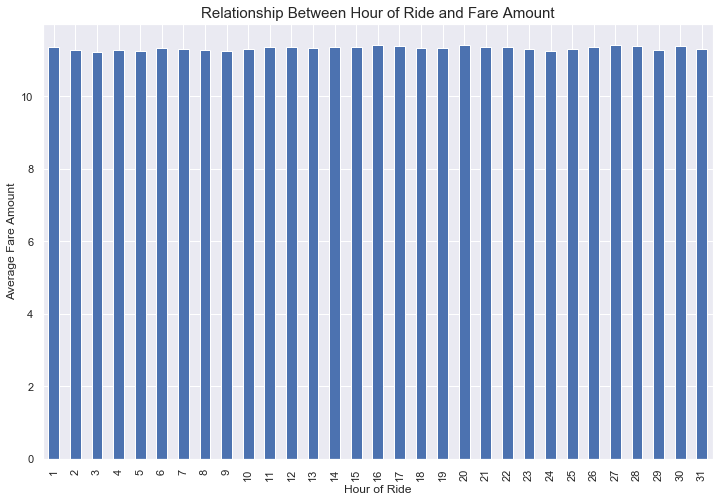

In [54]:
sns.set()
plt.figure(figsize=(12, 8))
train.groupby('pickup_day')['fare_amount'].mean().plot.bar()
plt.title("Relationship Between Hour of Ride and Fare Amount", fontsize=15)
plt.xlabel('Hour of Ride')
plt.ylabel('Average Fare Amount')